In [131]:
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from keras import optimizers
from keras.models import Sequential
from keras.regularizers import l1_l2
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [132]:
import image_tools

In [133]:
train = pd.read_csv('/Users/macbook/Mirror/JupyterProjects/Projects/Leukemia_data/train_paths.csv',index_col=0)
train.head()

,Image Paths,Image Labels
0,/Users/macbook/Mirror/JupyterProjects/Projects...,0
1,/Users/macbook/Mirror/JupyterProjects/Projects...,0
2,/Users/macbook/Mirror/JupyterProjects/Projects...,0
3,/Users/macbook/Mirror/JupyterProjects/Projects...,0
4,/Users/macbook/Mirror/JupyterProjects/Projects...,0


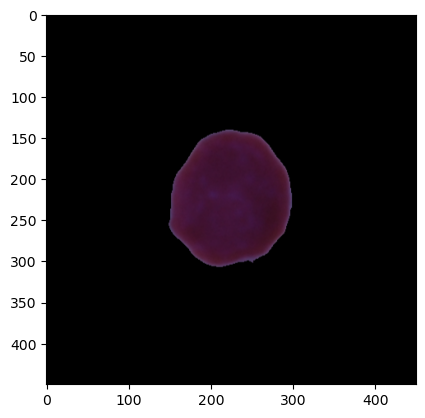

In [134]:
train['Image Paths'][1]
image_tools.ShowImage(train['Image Paths'][1])

In [135]:
val = pd.read_csv('/Users/macbook/Mirror/JupyterProjects/Projects/Leukemia_data/train_paths.csv',index_col=0)
val.head()

,Image Paths,Image Labels
0,/Users/macbook/Mirror/JupyterProjects/Projects...,0
1,/Users/macbook/Mirror/JupyterProjects/Projects...,0
2,/Users/macbook/Mirror/JupyterProjects/Projects...,0
3,/Users/macbook/Mirror/JupyterProjects/Projects...,0
4,/Users/macbook/Mirror/JupyterProjects/Projects...,0


In [136]:
val = val.rename(columns = {'labels':'Image Labels'})
val.columns

Index(['Image Paths', 'Image Labels'], dtype='object')

In [137]:
train = train.sample(frac=1, random_state=456)
val = val.sample(frac=1, random_state=456)

In [138]:
val = val.rename(columns = {'labels':'Image Labels'})
val.columns

Index(['Image Paths', 'Image Labels'], dtype='object')

In [139]:
def resize_image(image_path):

    resize_x = 200
    resize_y = 200
    image = cv.imread(image_path)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV)[1]
    result = cv.bitwise_and(image, image, mask=thresh)
    result[thresh==0] = [255,255,255] 
    (x, y, z_) = np.where(result > 0)
    minx = (np.min(x))
    maxx = (np.max(x))
    miny = (np.min(y))
    maxy = (np.max(y))
    crop_img = image[minx:maxx,miny:maxy,:]
    
    vborder = 0
    hborder = 0
    if (resize_y/resize_x) >= (crop_img.shape[0]/crop_img.shape[1]):
        vborder= int((((resize_y/resize_x)*crop_img.shape[1])-crop_img.shape[0])/2)
    else:
        hborder = int((((resize_y/resize_x)*crop_img.shape[0])-crop_img.shape[1])/2)
    
    crop_img = cv.copyMakeBorder(crop_img, vborder, vborder,
                                 hborder, hborder, cv.BORDER_CONSTANT, 0)
    resized_im = cv.resize(crop_img, (resize_x, resize_y))
    
    return cv.cvtColor(resized_im, cv.COLOR_BGR2GRAY)

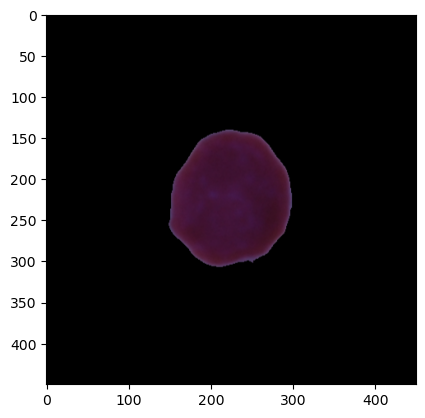

In [140]:
val['Image Paths'][1]
image_tools.ShowImage(val['Image Paths'][1])

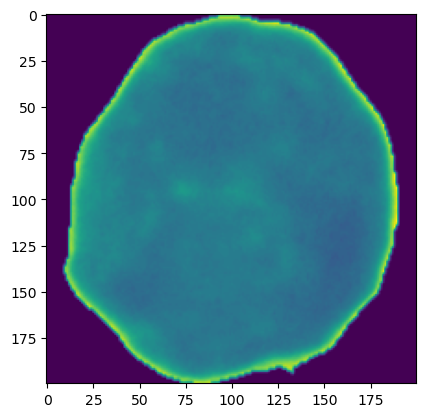

In [141]:
plt.imshow(resize_image(val['Image Paths'][1]))

In [142]:
# Decreasing the size of the data to speed up the training process
train = train[:3000]
val = val[:500]
val.shape

(500, 2)

In [143]:
xtrain = train['Image Paths'].apply(resize_image).values
ytrain = train['Image Labels'].values

xval = val['Image Paths'].apply(resize_image).values
yval = val['Image Labels'].values
xval.shape

print("xtrain :",xtrain.shape)
print("ytrain :",ytrain.shape)

print("xval :",xval.shape)
print("yval :",yval.shape)

xtrain : (3000,)
ytrain : (3000,)
xval : (500,)
yval : (500,)


In [144]:
# Rearraging the shape of the data
xtrain = np.stack(xtrain)
xval = np.stack(xval)
print(xval.shape)

xtrain = np.expand_dims(xtrain,axis=-1)
xval = np.expand_dims(xval,axis=-1)
print(xval.shape)

(500, 200, 200)
(500, 200, 200, 1)


In [145]:
xtrain, xtest, ytrain, ytest = train_test_split(xtrain, ytrain, 
                                                test_size=0.2, random_state=68)

print("xtrain :",xtrain.shape)
print("ytrain :",ytrain.shape)

print("xtest :",xtest.shape)
print("ytest :",ytest.shape)

print("xval :",xval.shape)
print("yval :",yval.shape)

xtrain : (2400, 200, 200, 1)
ytrain : (2400,)
xtest : (600, 200, 200, 1)
ytest : (600,)
xval : (500, 200, 200, 1)
yval : (500,)


In [146]:
input_shape = xtrain.shape[1:]

In [147]:
# Normalising the color vectors to lie between 0 and 1, rather than 0 and 255
xtrain = xtrain/255
xval = xval/255

In [148]:
del(train)
del(val)

In [149]:
init_model = Sequential()
init_model.add(Conv2D(filters = 2, kernel_size = (3,3),
                      padding = 'same',activation ='relu',
                      input_shape = input_shape))
init_model.add(Conv2D(filters = 4, kernel_size = (3,3),padding = 'same',activation ='relu'))
init_model.add(Conv2D(filters = 8, kernel_size = (4,4),padding = 'same',activation ='relu'))
init_model.add(MaxPool2D(pool_size=(2,2)))
init_model.add(Dropout(0.3))
init_model.add(Conv2D(filters = 16, kernel_size = (4,4),padding = 'same',activation ='relu'))
init_model.add(MaxPool2D(pool_size=(2,2)))
init_model.add(Conv2D(filters = 24, kernel_size = (6,6),padding = 'same',activation ='relu'))
init_model.add(Dropout(0.3))
init_model.add(Flatten())

init_model.add(Dense(32, kernel_regularizer=l1_l2(0.0001), activation = "relu"))
init_model.add(BatchNormalization())
init_model.add(Dense(24, kernel_regularizer=l1_l2(0.0001), activation = "relu"))
init_model.add(Dense(16, kernel_regularizer=l1_l2(0.0001), activation = "relu"))
init_model.add(Dense(1, activation = "sigmoid"))

In [150]:
init_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 200, 200, 2)       20        
                                                                 
 conv2d_11 (Conv2D)          (None, 200, 200, 4)       76        
                                                                 
 conv2d_12 (Conv2D)          (None, 200, 200, 8)       520       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 100, 8)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 100, 100, 8)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 100, 100, 16)      2064      
                                                      

In [151]:
init_model.compile(optimizer=Adam(0.1),loss='binary_crossentropy',metrics=['accuracy'])
init_train = init_model.fit(xtrain, ytrain, epochs = 25, validation_data = (xval, yval))

Epoch 1/25
75/75 [==============================] - 55s 704ms/step - loss: 26.0891 - accuracy: 0.6771 - val_loss: 2.6303 - val_accuracy: 0.7080
Epoch 2/25
75/75 [==============================] - 52s 692ms/step - loss: 1.6548 - accuracy: 0.6808 - val_loss: 1.6461 - val_accuracy: 0.7080
Epoch 3/25
75/75 [==============================] - 51s 676ms/step - loss: 1.7913 - accuracy: 0.6808 - val_loss: 2.1330 - val_accuracy: 0.7080
Epoch 4/25
75/75 [==============================] - 51s 678ms/step - loss: 2.1784 - accuracy: 0.6808 - val_loss: 2.4968 - val_accuracy: 0.7080
Epoch 5/25
75/75 [==============================] - 51s 677ms/step - loss: 2.4617 - accuracy: 0.6808 - val_loss: 2.7645 - val_accuracy: 0.7080
Epoch 6/25
75/75 [==============================] - 56s 750ms/step - loss: 2.6631 - accuracy: 0.6808 - val_loss: 2.9234 - val_accuracy: 0.7080
Epoch 7/25
75/75 [==============================] - 53s 711ms/step - loss: 2.8121 - accuracy: 0.6808 - val_loss: 3.0864 - val_accuracy: 0.708

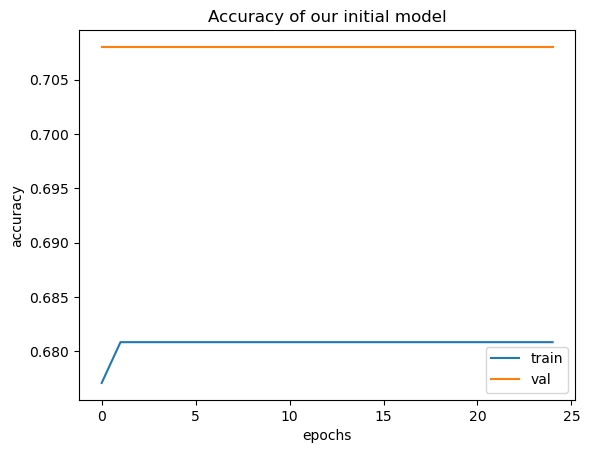

In [153]:
# Plotting the accuracy:
plt.plot(init_train.history['accuracy'])
plt.plot(init_train.history['val_accuracy'])
plt.title('Accuracy of our initial model')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='lower right')
plt.show()